In [1]:
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import scipy.stats as stats
from scipy.stats import norm
from scipy.stats import gamma
from scipy.stats import genextreme as gev

from pyextremes import EVA

In [2]:
# Load the ERA5 reanalysis daily precipitation data for different locations
location = 'Ilulissat' # Inuvik, Longyearbyen, Deadhorse, Ilulisat

file_path = f'Data/ERA5_Arctic_TP_daysum_{location}_1940-2023.nc' # will change automatically once you adjusted the location

daily_precipitation = xr.open_dataset(file_path)
# Add an attribute to the dataset
daily_precipitation.attrs['units'] = 'm/d' #you can check the units in the attributes listed in the table created by printing the loaded database
# create a array which only conains the years 
years = daily_precipitation['time'].dt.year.values

# Print the loaded data base
daily_precipitation

<xarray.Dataset> Size: 1MB
Dimensions:    (time: 30681, bnds: 2, longitude: 2, latitude: 2)
Coordinates:
  * time       (time) datetime64[ns] 245kB 1940-01-01T15:00:00 ... 2023-12-31...
  * longitude  (longitude) float32 8B -51.25 -51.0
  * latitude   (latitude) float32 8B 69.25 69.0
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) datetime64[ns] 491kB ...
    tp         (time, latitude, longitude) float32 491kB ...
Attributes:
    CDI:          Climate Data Interface version 2.0.5 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Sep 19 15:45:40 2024: cdo mergetime ERA5_Arctic_TP_days...
    frequency:    day
    CDO:          Climate Data Operators version 2.0.5 (https://mpimet.mpg.de...
    units:        m/d

In [3]:
# take the mean precipitation over the entire area
daily_precipitation = daily_precipitation.mean(dim=['latitude','longitude'])

In [4]:
# Calculate monthly sums
monthly_sum_precipitation = daily_precipitation.resample(time='ME').sum(dim='time') # ME adjusted from 1m - deprication warning!
# Calaculate a mean of monthly sums from the years
annual_mean_precipitation_monthly_sum = monthly_sum_precipitation.groupby('time.month').mean(dim='time')


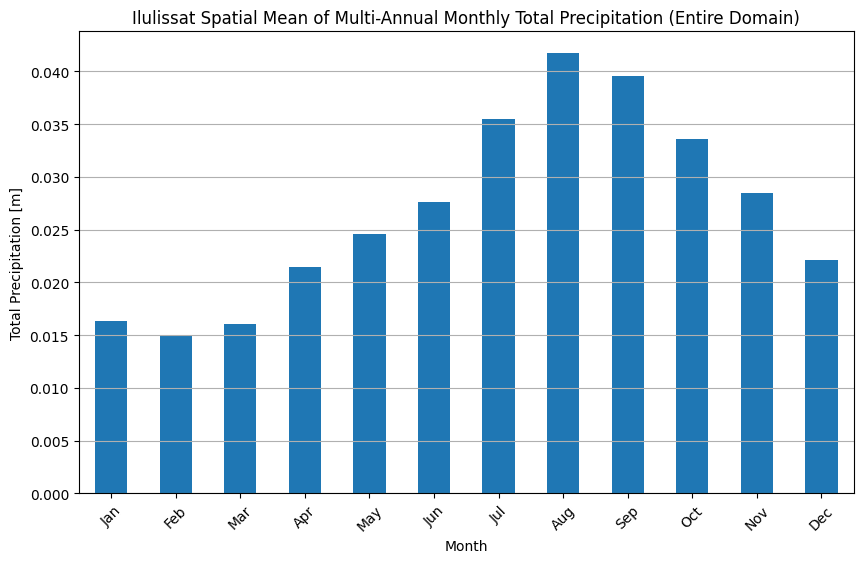

In [5]:
# Convert DataArray to pandas DataFrame for easier plotting
df = annual_mean_precipitation_monthly_sum.to_dataframe()

# Plot mean monthly precipitation of multi-annual means as a bar plot
df['tp'].plot(kind='bar', figsize=(10, 6))
plt.title(f'{location} Spatial Mean of Multi-Annual Monthly Total Precipitation (Entire Domain)')
plt.xlabel('Month')
plt.ylabel('Total Precipitation [m]')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(axis='y')
plt.show()

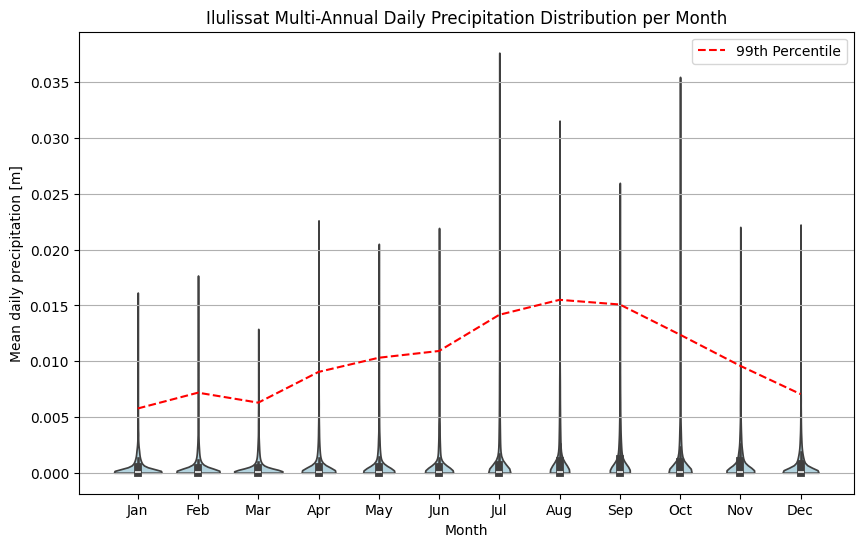

In [6]:
# A diffrent way of ploting the precipitation allows us to learn something
# about distribution of values within the months

# First calaculate spatial mean for daily values which are grouped by month
spatial_mean_daily_precipitation_monthly = daily_precipitation['tp'].groupby('time.month')

# Prepare data for violin plots (daily values must be stored in lists for every month)
data_list = []
data_99p_list = []
months = range(1, 13)  # Months range from 1 to 12
for m in months:
    # Extract data for each month
    data_month = spatial_mean_daily_precipitation_monthly[m]  
    # Calaculate 99% percentile for each month
    data_month_99p = data_month.reduce(np.percentile, q=99, dim='time')   
    # store data into lists for each month 
    data_list.append(data_month.values)
    data_99p_list.append(data_month_99p.values)
    
# Create violin plots we use the seaborn libary
plt.figure(figsize=(10, 6))
sns.violinplot(data=data_list, cut=0, color = 'lightblue')
plt.title(f'{location} Multi-Annual Daily Precipitation Distribution per Month')
plt.xlabel('Month')
plt.ylabel('Mean daily precipitation [m]')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(axis='y')

plt.plot(np.arange(0,12,1),data_99p_list, color='r', linestyle='--', label=f'99th Percentile')
plt.legend()
plt.show()

In [7]:
# Optain array of precipitation data from the xarray
daily_mean = daily_precipitation['tp']

# filter out only wet days (daily precipitation > 1mm --> BUT data in m 
daily_mean_wet = daily_mean[(daily_mean > 0.001)]
daily_mean_dry = daily_mean[(daily_mean <= 0.001)]

n_days = daily_mean.size
n_wet_days = daily_mean_wet.size
n_dry_days = daily_mean_dry.size

p_wet_day = n_wet_days/n_days

print(f'In total there are {n_wet_days:.0f} wet days out of {n_days:.0f} observations in {location}')
print(f'The mean daily propabilty of wet day is {p_wet_day:.2f} dry days out of {n_days:.0f} observations in {location}')

In total there are 6270 wet days out of 30681 observations in Ilulissat
The mean daily propabilty of wet day is 0.20 dry days out of 30681 observations in Ilulissat


In [8]:
# Calculate mean, median, and percentiles in mm
mean_precip = daily_mean_wet.mean().values
median_precip = np.nanmedian(daily_mean_wet.values)
percentile_95 = np.nanpercentile(daily_mean_wet.values, 95)
percentile_99 = np.nanpercentile(daily_mean_wet.values, 99)

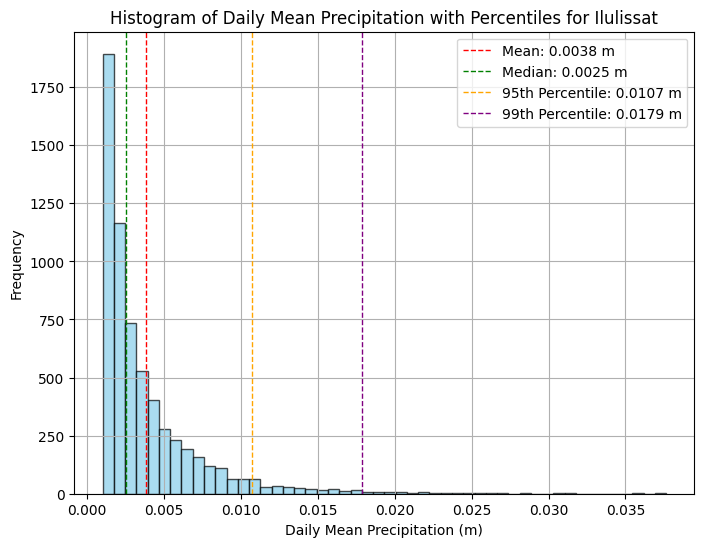

In [9]:
# Plot the histogram
plt.figure(figsize=(8, 6))
plt.hist(daily_mean_wet, bins=50, alpha=0.7, color='skyblue', edgecolor='black')

# Add lines for mean, median, and percentiles
plt.axvline(mean_precip, color='red', linestyle='dashed', linewidth=1, label=f'Mean: {mean_precip:.4f} m')
plt.axvline(median_precip, color='green', linestyle='dashed', linewidth=1, label=f'Median: {median_precip:.4f} m')
plt.axvline(percentile_95, color='orange', linestyle='dashed', linewidth=1, label=f'95th Percentile: {percentile_95:.4f} m')
plt.axvline(percentile_99, color='purple', linestyle='dashed', linewidth=1, label=f'99th Percentile: {percentile_99:.4f} m')

# Plot legend, labels, and title
plt.legend()
plt.xlabel('Daily Mean Precipitation (m)')
plt.ylabel('Frequency')
plt.title(f'Histogram of Daily Mean Precipitation with Percentiles for {location}')
plt.grid(True)
plt.show()

In [10]:
# Create a DataFrame for better organization and visualization
df = pd.DataFrame({'Date': daily_mean_wet['time'], 'DailyRecords': daily_mean_wet.values})
df

,Date,DailyRecords
0,1940-01-02 11:00:00,0.001077
1,1940-01-10 11:00:00,0.003130
2,1940-01-14 11:00:00,0.001780
3,1940-02-29 11:00:00,0.002178
4,1940-03-12 11:00:00,0.001548
...,...,...
6265,2023-12-11 11:00:00,0.004925
6266,2023-12-12 11:00:00,0.004116
6267,2023-12-13 11:00:00,0.002602
6268,2023-12-14 11:00:00,0.001608


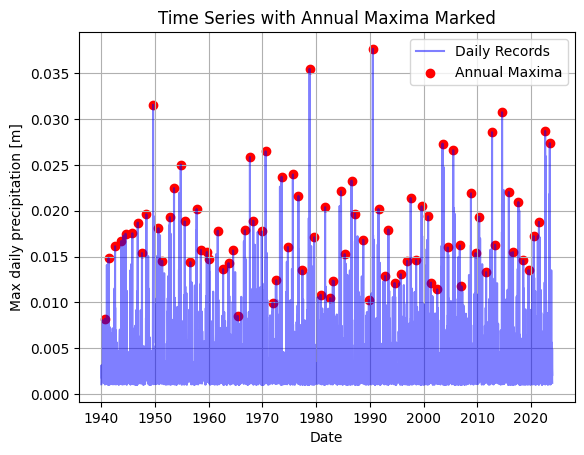

In [11]:
# Now we use an approach from Extreme Value Analysis

# Extract year from the 'Date' column
df['Year'] = df['Date'].dt.year

# Find annual maxima and corresponding dates (Block Maximum)
annual_maxima = df.loc[df.groupby('Year')['DailyRecords'].idxmax()]

# Plot the time series
plt.plot(df['Date'], df['DailyRecords'], label='Daily Records', linestyle='-', color='b', alpha=0.5)
# Mark the annual maxima on the plot
plt.scatter(annual_maxima['Date'], annual_maxima['DailyRecords'], color='red', marker='o', label='Annual Maxima')
plt.title('Time Series with Annual Maxima Marked')
plt.xlabel('Date')
plt.ylabel('Max daily precipitation [m]')
plt.legend()
plt.grid(True)
plt.show()

This dataframe stores the dates of all the 'wet' days (e.g. >1 mm of precipitation)

The following analysis is based on the block maximum method and calculates the return period for events > 30 mm. 

In [12]:
annual_maxima

,Date,DailyRecords,Year
38,1940-09-09 11:00:00,0.008203,1940
78,1941-05-09 11:00:00,0.014837,1941
149,1942-07-24 11:00:00,0.016129,1942
205,1943-09-11 11:00:00,0.016697,1943
275,1944-07-05 11:00:00,0.017492,1944
...,...,...,...
5862,2019-07-19 11:00:00,0.013520,2019
5926,2020-07-10 11:00:00,0.017225,2020
6017,2021-06-29 11:00:00,0.018779,2021
6126,2022-08-23 11:00:00,0.028699,2022


In [13]:
# Now we fit the GEV function to the annual maxima
gev_shape, gev_loc, gev_scale = gev.fit(annual_maxima['DailyRecords'])

Text(0, 0.5, 'Frequency')

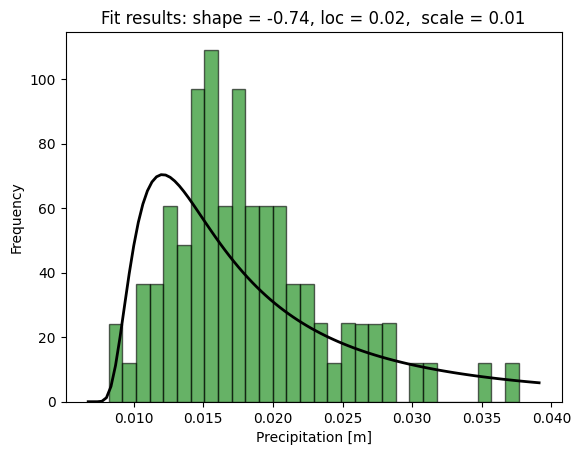

In [14]:
# Create histogram
plt.hist(annual_maxima['DailyRecords'], bins=30, density=True, alpha=0.6, color='g', edgecolor='black')

# Plot the fitted function
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = gev(gev_shape,gev_loc,gev_scale).pdf(x)
plt.plot(x, p, 'k', linewidth=2)

# Add labels and title
plt.title(f'Fit results: shape = {gev_shape:.2f}, loc = {gev_loc:.2f},  scale = {gev_scale:.2f}')
plt.xlabel('Precipitation [m]')
plt.ylabel('Frequency')

In [15]:
event_threshold = 0.0179
# Model the return period based on the GEV function usinfg the same threshold value  
p_annual_extreme = 1 - gev(gev_shape,gev_loc,gev_scale).cdf(event_threshold)
return_period_extreme = 1/p_annual_extreme
print(return_period_extreme)

2.0134501396288447


 Perform an analysis for all the regions listed and think of a way to visualise/summarise this in a comprehensible way

 For this you need to think about a suitable way to show this (e.g. figures/tables etc)
 You also need to think about differences between the regions
     - should the threshold be the same?
     - what are the differences in precipitation patterns?

Tips:
start with comparing precipitation patterns

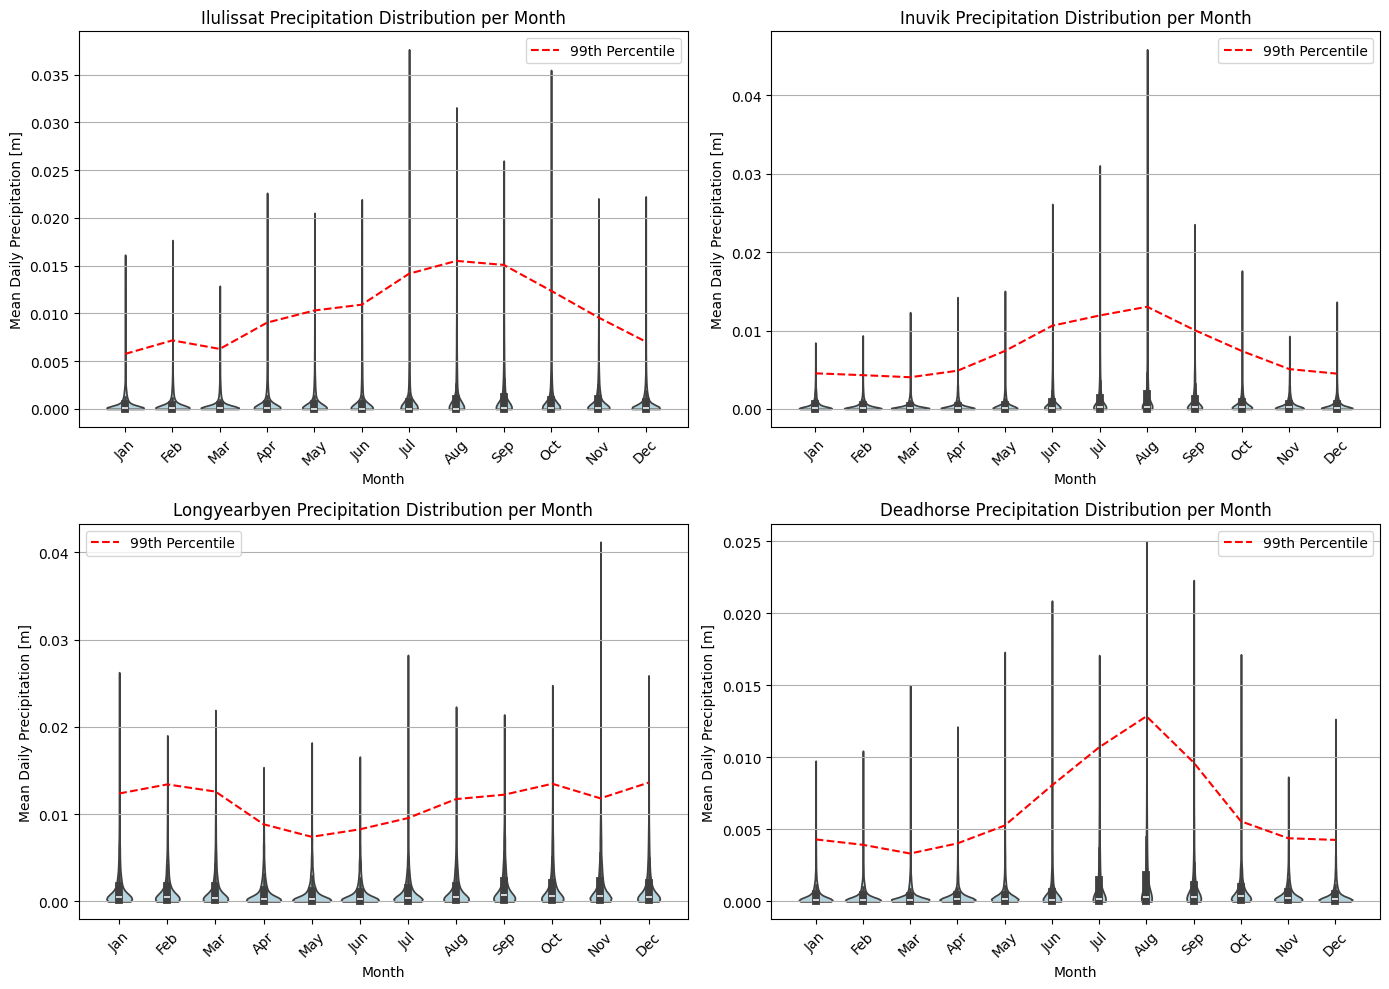

In [16]:
# Define locations to loop over
locations = ['Ilulissat', 'Inuvik', 'Longyearbyen', 'Deadhorse']

# Initialize a figure with 2x2 subplots
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

# Loop through each location and create violin plots
for i, location in enumerate(locations):
    file_path = f'Data/ERA5_Arctic_TP_daysum_{location}_1940-2023.nc'
    
    # Load dataset for the location
    daily_precipitation = xr.open_dataset(file_path)
    daily_precipitation = daily_precipitation.mean(dim=['latitude', 'longitude'])
    
    # Group daily precipitation by month
    spatial_mean_daily_precipitation_monthly = daily_precipitation['tp'].groupby('time.month')
    
    # Prepare data for violin plots
    data_list = []
    data_99p_list = []
    for m in range(1, 13):
        data_month = spatial_mean_daily_precipitation_monthly[m]  
        data_month_99p = data_month.reduce(np.percentile, q=99, dim='time')  
        data_list.append(data_month.values)
        data_99p_list.append(data_month_99p.values)
    
    # Create the violin plot for the current location
    sns.violinplot(data=data_list, cut=0, color='lightblue', ax=axes[i])
    axes[i].set_title(f'{location} Precipitation Distribution per Month')
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Mean Daily Precipitation [m]')
    axes[i].set_xticks(range(12))
    axes[i].set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
    axes[i].grid(axis='y')

    # Plot the 99th percentile line for the current location
    axes[i].plot(np.arange(0, 12, 1), data_99p_list, color='r', linestyle='--', label=f'99th Percentile')
    axes[i].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [17]:
# Initialize a list to store the results
results = []

# Loop through each location
for location in locations:
    file_path = f'Data/ERA5_Arctic_TP_daysum_{location}_1940-2023.nc'
    
    # Load dataset for the location
    daily_precipitation = xr.open_dataset(file_path)
    daily_precipitation = daily_precipitation.mean(dim=['latitude', 'longitude'])
    
    # Filter wet days (daily precipitation > 1mm)
    daily_mean_wet = daily_precipitation['tp'][(daily_precipitation['tp'] > 0.001)]
    
    # Calculate the 99th percentile as the threshold for extreme events
    threshold_99p = np.nanpercentile(daily_mean_wet.values, 99)
    
    # Convert dataset to pandas DataFrame for easier manipulation
    df = pd.DataFrame({'Date': daily_mean_wet['time'].values, 'DailyRecords': daily_mean_wet.values})
    
    # Extract year from the 'Date' column
    df['Year'] = df['Date'].dt.year
    
    # Find annual maxima using the block maxima approach
    annual_maxima = df.loc[df.groupby('Year')['DailyRecords'].idxmax()]
    
    # Fit the GEV distribution to the annual maxima
    gev_shape, gev_loc, gev_scale = gev.fit(annual_maxima['DailyRecords'])
    
    # Calculate the return period for the 99th percentile threshold
    p_annual_extreme = 1 - gev.cdf(threshold_99p, gev_shape, gev_loc, gev_scale)
    return_period_extreme = 1 / p_annual_extreme
    
    # Store the results in the list
    results.append([location, threshold_99p, return_period_extreme])

# Create a DataFrame from the results list
df_results = pd.DataFrame(results, columns=['Location', '99th Percentile Threshold (m)', 'Return Period (years)'])

# Display the table
print(df_results)

# Optional: You can also save this DataFrame to a CSV file if needed
#df_results.to_csv('Data/return_periods_by_location.csv', index=False)

       Location  99th Percentile Threshold (m)  Return Period (years)
0     Ilulissat                       0.017869               2.008374
1        Inuvik                       0.013849               2.091569
2  Longyearbyen                       0.014974               1.655754
3     Deadhorse                       0.012690               1.987549


In [22]:
# Define a fixed threshold for all regions (e.g., 0.020m)
fixed_threshold = 0.020

# Initialize a list to store the results
results = []

# Loop through each location
for location in locations:
    file_path = f'Data/ERA5_Arctic_TP_daysum_{location}_1940-2023.nc'
    
    # Load dataset for the location
    daily_precipitation = xr.open_dataset(file_path)
    daily_precipitation = daily_precipitation.mean(dim=['latitude', 'longitude'])
    
    # Filter wet days (daily precipitation > 1mm)
    daily_mean_wet = daily_precipitation['tp'][(daily_precipitation['tp'] > 0.001)]
    
    # Calculate the 99th percentile as the threshold for extreme events
    threshold_99p = np.nanpercentile(daily_mean_wet.values, 99)
    
    # Convert dataset to pandas DataFrame for easier manipulation
    df = pd.DataFrame({'Date': daily_mean_wet['time'].values, 'DailyRecords': daily_mean_wet.values})
    
    # Extract year from the 'Date' column
    df['Year'] = df['Date'].dt.year
    
    # Find annual maxima using the block maxima approach
    annual_maxima = df.loc[df.groupby('Year')['DailyRecords'].idxmax()]
    
    # Fit the GEV distribution to the annual maxima
    gev_shape, gev_loc, gev_scale = gev.fit(annual_maxima['DailyRecords'])
    
    # Calculate the return period for the 99th percentile threshold
    p_annual_extreme_99p = 1 - gev.cdf(threshold_99p, gev_shape, gev_loc, gev_scale)
    return_period_extreme_99p = 1 / p_annual_extreme_99p
    
    # Calculate the return period for the fixed threshold (e.g., 0.020 m)
    p_annual_extreme_fixed = 1 - gev.cdf(fixed_threshold, gev_shape, gev_loc, gev_scale)
    return_period_extreme_fixed = 1 / p_annual_extreme_fixed
    
    # Find the maximum precipitation event from the data
    max_precipitation = df['DailyRecords'].max()
    
    # Calculate the return period for the maximum precipitation event
    p_annual_extreme_max = 1 - gev.cdf(max_precipitation, gev_shape, gev_loc, gev_scale)
    return_period_extreme_max = 1 / p_annual_extreme_max
    
    # Store the results in the list
    results.append([location, 
                    threshold_99p, return_period_extreme_99p, 
                    fixed_threshold, return_period_extreme_fixed, 
                    max_precipitation, return_period_extreme_max])

# Create a DataFrame from the results list
df_results = pd.DataFrame(results, columns=[
    'Location', 
    '99th %-tile Threshold (m)', 'Return Period (99th %-tile)', 
    'Fixed Threshold (m)', 'Return Period (Fixed Threshold)', 
    'Max Precipitation (m)', 'Return Period (Max Precipitation)'
])

# Display the table
print(df_results)

# Optional: You can also save this DataFrame to a CSV file if needed
df_results.to_csv('return_periods_by_location_extended.csv', index=False)

       Location  99th %-tile Threshold (m)  Return Period (99th %-tile)  \
0     Ilulissat                   0.017869                     2.008374   
1        Inuvik                   0.013849                     2.091569   
2  Longyearbyen                   0.014974                     1.655754   
3     Deadhorse                   0.012690                     1.987549   

   Fixed Threshold (m)  Return Period (Fixed Threshold)  \
0                 0.02                         2.365771   
1                 0.02                         6.038875   
2                 0.02                         2.888241   
3                 0.02                         3.780542   

   Max Precipitation (m)  Return Period (Max Precipitation)  
0               0.037651                           6.036461  
1               0.045891                         191.968628  
2               0.041223                          10.466911  
3               0.024963                           5.205180  
